# Plotting intermidiate network results

In [64]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 0 folder(s) up.


# Load networks

In [65]:
#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

clustered_network = os.getcwd() + '/networks/elec_s_22.nc'
n_cluster = pypsa.Network(clustered_network)

#solved_network = r'C:\Users\Lenovo\Desktop\pypsa-earth\Result_analysis\2020_4N_1Y_1H_CP20_NI_CL_WH\results\networks\elec_s_4_ec_lcopt_Co2L-1H.nc'
solved_network = os.getcwd() + "/results/networks/elec_s_22_ec_lcopt_Co2L-1H.nc"
n_solve = pypsa.Network(solved_network)

base_network= os.getcwd() +  "/networks/base.nc"
n_base= pypsa.Network(base_network)



INFO:pypsa.io:Imported network elec_s_22.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_22_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


In [66]:
n_cluster

PyPSA Network
Components:
 - Bus: 22
 - Carrier: 13
 - Generator: 63
 - Line: 29
 - Load: 22
 - StorageUnit: 8
Snapshots: 8760

In [67]:
n_base

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 155
 - Line: 322
 - Transformer: 39
Snapshots: 8760

(<matplotlib.collections.PatchCollection at 0x1f70851ddb0>,
 <matplotlib.collections.LineCollection at 0x1f708478bb0>)

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


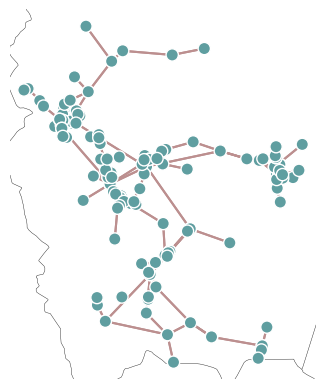

In [68]:
n_base.plot()

In [69]:
n_solve

PyPSA Network
Components:
 - Bus: 66
 - Carrier: 16
 - Generator: 85
 - GlobalConstraint: 1
 - Line: 29
 - Link: 88
 - Load: 22
 - StorageUnit: 8
 - Store: 44
Snapshots: 8760

# Solved network

In [70]:
n = n_solve

# Node distribution

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


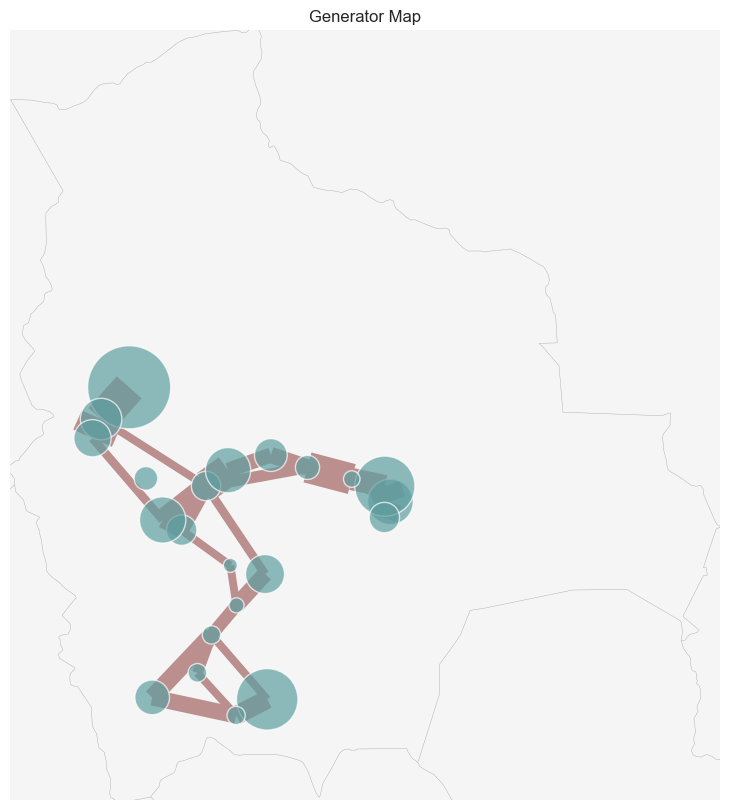

In [71]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=ax,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=0.7,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    )*0.5,  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 1e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16304\1033421008.py:182: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


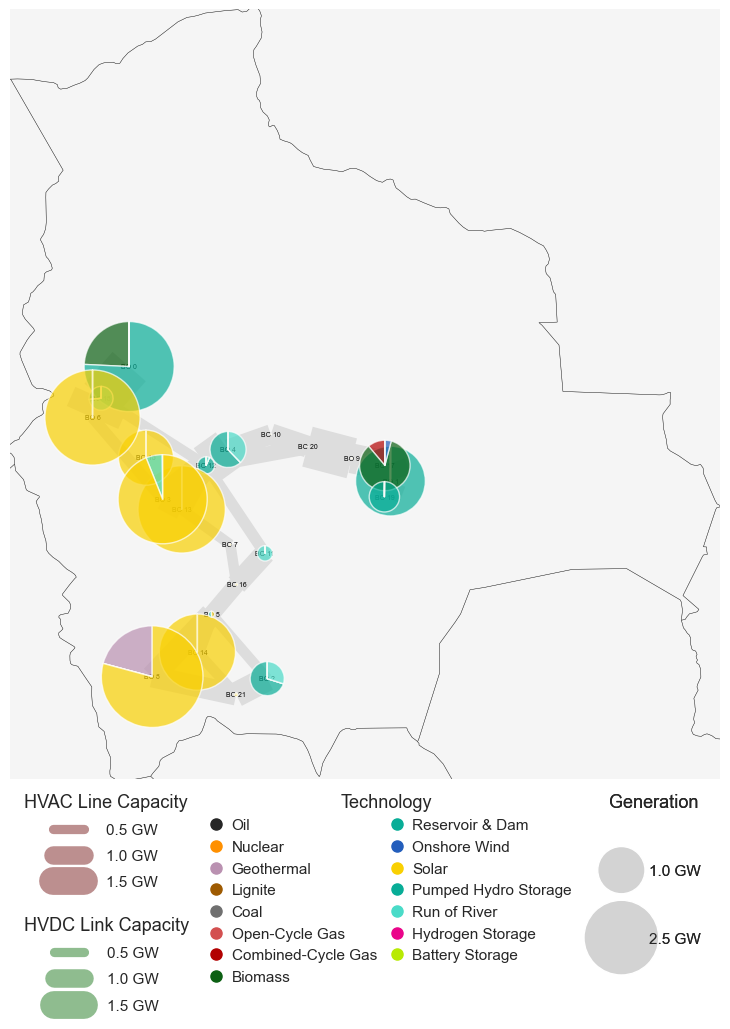

In [72]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0, 1.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    for s in (0.5, 1.0, 1.5):
        handles.append(
            plt.Line2D(
                [0], [0], color="darkseagreen", linewidth=s * 1e3 / branch_factor
            )
        )
        labels.append(f"{s} GW")
    l2 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.0, -0.16),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVDC Link Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l2)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    for name, carrier in n.carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )
        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [10, 25]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.5,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 6.0e3
    branch_factor = 7.5e1

    fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    
    # Add bus names to the plot
    for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
        ax.text(lon, lat, bus, fontsize=5, color='black', ha='center', va='center')


    add_legend(ax, bus_factor, branch_factor)

    ### section added to define the national border
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes=world[world.name.isin(["Bolivia"])].set_index("name")
    ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

# Expansion analysis

In [73]:
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)
# Eur/Year

n.objective

2424197975.156649

# Generation expansion analysis

In [74]:
# Check generators total capacities nominal (p_nom) optimized (p_nom_opt) 
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16304\2871636601.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,NaN,0.000000,1.236000e+02,3.608394e+05,1.500,123.6,38.668224,0,1.236000e+02,3.000,0,0,0,3,0,0.0,3.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,3.0,3.0
OCGT,NaN,0.000000,0.000000e+00,5.302080e+05,1.950,0.0,71.972842,0,0.000000e+00,5.000,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0
biomass,NaN,0.000000,9.900000e+01,3.928889e+05,0.936,99.0,29.934203,2,1.793000e+03,2.000,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
geothermal,inf,0.000000,5.500000e+01,2.960868e+05,0.239,55.0,0.010049,1,9.350000e+02,1.000,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
load,NaN,0.000000,2.200000e+10,0.000000e+00,22.000,0.0,22.219943,0,2.200000e+10,0.022,0,0,0,22,0,0.0,22.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,22.0,22.0
oil,inf,0.000000,0.000000e+00,3.676253e+04,0.393,0.0,130.235547,0,0.000000e+00,1.000,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
onwind,2.375877e+06,160337.837381,4.500000e+01,2.848179e+06,22.000,45.0,0.544668,22,4.728087e+01,22.000,0,0,0,22,0,0.0,22.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,22.0,22.0
ror,NaN,863.770000,8.637700e+02,1.264554e+06,6.300,0.0,0.071498,0,8.637700e+02,7.000,0,0,0,7,0,0.0,7.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,7.0,7.0
solar,1.869811e+06,330825.879637,1.004000e+02,1.118831e+06,22.000,100.4,0.443763,22,1.790811e+04,22.000,0,0,0,22,0,0.0,22.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,22.0,22.0


In [75]:
#installed capacity expansion
generation_expansion = gen_cap['p_nom_opt'] - gen_cap['p_nom']
generation_expansion

carrier
CCGT              0.000000
OCGT              0.000000
biomass        1693.999995
geothermal      879.999994
load              0.000000
oil               0.000000
onwind            2.280866
ror               0.000000
solar         17807.707442
dtype: float64

In [76]:
generation_expansion.sum()

20383.98829793975

# Energy production analysis

In [77]:
#energy generated by type of powerplant
production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()
production_cap.sum()

carrier
CCGT          1.082318e+06
OCGT          0.000000e+00
biomass       1.556593e+07
geothermal    8.179488e+06
load          1.844376e+07
oil           0.000000e+00
onwind        4.346010e+04
ror           4.865381e+06
solar         3.256214e+07
dtype: float64

# Transmission expansion analysis

In [78]:
#Transmission lines 
lines = n.lines
lines

,bus0,bus1,length,type,s_max_pu,s_nom,capital_cost,num_parallel,s_nom_extendable,s_nom_min,x,r,b,build_year,carrier,x_pu_eff,r_pu_eff,s_nom_opt,v_nom,g,s_nom_max,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,BO 0,BO 18,98.621034,Al/St 240/40 4-bundle 380.0,0.7,1966.224077,3757.729747,1.157895,True,1138.340255,20.952487,2.555181,0.000495,0,AC,0.000433,0.000053,2395.442115,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,BO 1,BO 17,39.080875,Al/St 240/40 4-bundle 380.0,0.7,3932.448154,1488.978392,2.315789,True,2276.680510,4.151455,0.506275,0.000392,0,AC,0.000086,0.000010,2276.680718,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,BO 1,BO 19,39.618137,Al/St 240/40 4-bundle 380.0,0.7,2949.336115,1509.820508,1.736842,True,1707.510382,5.611369,0.684313,0.000298,0,AC,0.000116,0.000014,1707.510714,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,BO 1,BO 9,102.628354,Al/St 240/40 4-bundle 380.0,0.7,983.112038,3910.454556,0.578947,True,569.170127,43.607721,5.318015,0.000258,0,AC,0.000901,0.000110,731.423776,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,BO 10,BO 20,87.914178,Al/St 240/40 4-bundle 380.0,0.7,983.112038,3349.085976,0.578947,True,569.170127,37.355533,4.555553,0.000221,0,AC,0.000772,0.000094,1174.695736,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,BO 10,BO 4,103.273961,Al/St 240/40 4-bundle 380.0,0.7,983.112038,3935.326899,0.578947,True,569.170127,43.882045,5.351469,0.000259,0,AC,0.000907,0.000111,1078.161217,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,BO 11,BO 12,246.923513,Al/St 240/40 4-bundle 380.0,0.7,983.112038,9406.789831,0.578947,True,569.170127,104.920046,12.795128,0.000620,0,AC,0.002168,0.000264,619.381409,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
8,BO 11,BO 16,97.699979,Al/St 240/40 4-bundle 380.0,0.7,1966.224077,3722.456680,1.157895,True,1138.340255,20.756805,2.531318,0.000490,0,AC,0.000429,0.000052,1138.341212,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
9,BO 11,BO 5,187.008348,Al/St 240/40 4-bundle 380.0,0.7,983.112038,7125.650288,0.578947,True,569.170127,79.461547,9.690433,0.000469,0,AC,0.001642,0.000200,569.213000,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [79]:
lines.s_nom.sum()

45223.153765300354

In [80]:
#transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']
transmission_expansion

Line
1      429.218039
2    -1655.767436
3    -1241.825401
4     -251.688262
5      191.583698
6       95.049179
7     -363.730630
8     -827.882864
9     -413.899038
10      55.303799
11    -413.941814
12    -155.821625
13    -420.466673
14   -1655.093992
15    -827.856125
16    -413.908819
17    -413.941800
18    -210.381600
19     -80.776707
20    -413.927736
21    -413.927371
22    -362.651580
23    -889.872196
24     361.732414
25    -413.939878
26     254.854385
27     178.618454
28    -366.638270
29     260.341405
dtype: float64

In [81]:
real_expansion = 0
for i in range(len(transmission_expansion)):  # Iterate over the indices of the Series
    if transmission_expansion.iloc[i] > 0:  # Check if the expansion value is greater than 0
        real_expansion += transmission_expansion.iloc[i]  # Add the expansion value to real_expansion

print("Total expansion of the system:", real_expansion)

Total expansion of the system: 1826.7013732439227


In [82]:
max_line_expansion = transmission_expansion.max()
max_line_expansion

429.21803866417235

In [83]:
load_shedding = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()["load"]
load_shedding.sum()

18443755.888762083

# Operational parameters

In [84]:
n.objective/1000000

2424.197975156649

In [85]:
n.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                9.910390e-01         3.522249e+08   
            Combined-Cycle Gas     9.996143e-01         1.486658e+07   
            Geothermal             9.986434e-01         2.768412e+08   
            Oil                             NaN         0.000000e+00   
            Onshore Wind           1.049304e-01         6.121109e+06   
            Open-Cycle Gas                  NaN         0.000000e+00   
            Run of River           6.430054e-01         1.560406e+08   
            Solar                  2.075674e-01         9.107340e+08   
            load                   9.570234e-08         0.000000e+00   
Line        AC                     3.444924e-01         1.398288e+08   
Link        H2 electrolysis        2.447038e-01         8.540001e+07   
            H2 fuel cell           9.175571e-02         9.132904e+07   
            battery charger        2.408412e-01         1.360336e+08   
            battery discharger     1.950814e-01         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam        6.575917e-01         1.076876e+09   
Store       Battery Storage        4.041805e-01         3.071057e+08   
            Hydrogen Storage       5.118766e-01         7.560657e+07   

                                Curtailment  Installed Capacity  \
            carrier                                               
Generator   Biomass                0.000000        9.900000e+01   
            Combined-Cycle Gas     0.000000        1.236000e+02   
            Geothermal             0.000000        5.500000e+01   
            Oil                    0.000000        0.000000e+00   
            Onshore Wind           0.129636        4.500000e+01   
            Open-Cycle Gas         0.000000        0.000000e+00   
            Run of River           1.807748        8.637700e+02   
            Solar                 38.818593        1.004000e+02   
            load                   0.000000        2.200000e+10   
Line        AC                          NaN        4.522315e+04   
Link        H2 electrolysis             NaN        0.000000e+00   
            H2 fuel cell                NaN        0.000000e+00   
            battery charger             NaN        0.000000e+00   
            battery discharger          NaN        0.000000e+00   
Load        -                           NaN                 NaN   
StorageUnit Reservoir & Dam        0.000000        6.077320e+03   
Store       Battery Storage             NaN        0.000000e+00   
            Hydrogen Storage            NaN        0.000000e+00   

                                Operational Expenditure  Optimal Capacity  \
            carrier                                                         
Generator   Biomass                        2.659560e+04      1.793000e+03   
            Combined-Cycle Gas             1.592491e+03      1.236000e+02   
            Geothermal                     9.383455e+00      9.350000e+02   
            Oil                            0.000000e+00      0.000000e+00   
            Onshore Wind                   1.200327e-01      4.728087e+01   
            Open-Cycle Gas                 0.000000e+00      0.000000e+00   
            Run of River                   5.715546e+00      8.637700e+02   
            Solar                          7.543917e+01      1.790811e+04   
            load                           2.125433e+03      2.200000e+10   
Line        AC                                      NaN      3.484192e+04   
Link        H2 electrolysis                0.000000e+00      1.750201e+03   
            H2 fuel cell                   0.000000e+00      3.734096e+03   
            battery charger                0.000000e+00      3.532632e+03   
            battery discharger             0.000000e+00      3.925147e+03   
Load        -     

In [86]:
# Capital expenditure for optimized values (annual values based on p_nom_opt) [Eur/year]
n.statistics.capex().sum()

3629007886.2695994

In [87]:
# Capital expenditure (annual values based on p_nom_opt) [Eur/year]
n.statistics.opex(aggregate_time="sum").sum()

266700450.18830413

In [88]:
#manual sum of components to obtain capex of the system [Million Eur/year]
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6).sum()  + (n.storage_units.p_nom_opt * n.storage_units.capital_cost).div(1e6).sum() + (n.lines.s_nom_opt * n.lines.capital_cost).div(1e6).sum() + (n.stores.e_nom_opt * n.stores.capital_cost).div(1e6).sum()# M€/a
capex

3316.245211639827

In [89]:
#manual sum of components to obatin opex of the system [Million Eur/year]
opex = (n.snapshot_weightings.generators @ n.generators_t.p * (n.generators.marginal_cost).div(1e6)).sum() + (n.snapshot_weightings.generators @ n.storage_units_t.p * (n.storage_units.marginal_cost).div(1e6)).sum()  # M€/a
opex

266.7004501883038

In [90]:
#manual sum of components to obtain capex of only the expanded capacity (p_nom_opt-p_nom) [Million Eur/year]
capex2 = ((n.generators.p_nom_opt - n.generators.p_nom)* n.generators.capital_cost).div(1e6).sum()  + ((n.storage_units.p_nom_opt - n.storage_units.p_nom ) * n.storage_units.capital_cost).div(1e6).sum() + ((n.lines.s_nom_opt - n.lines.s_nom) * n.lines.capital_cost).div(1e6).sum() + ((n.stores.e_nom_opt - n.stores.e_nom) * n.stores.capital_cost).div(1e6).sum()# M€/a
capex2

1844.7348561703357

<AxesSubplot:xlabel='snapshot'>

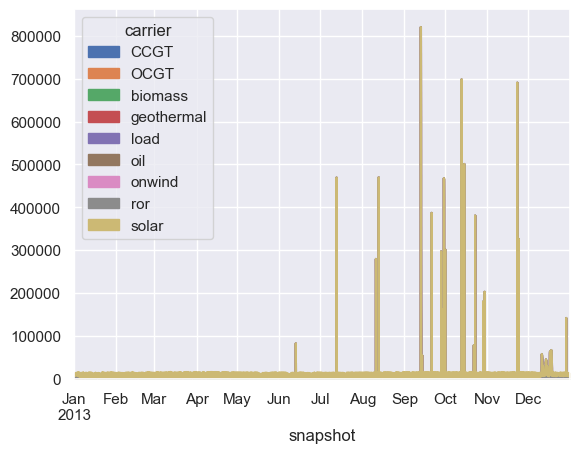

In [91]:
n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")

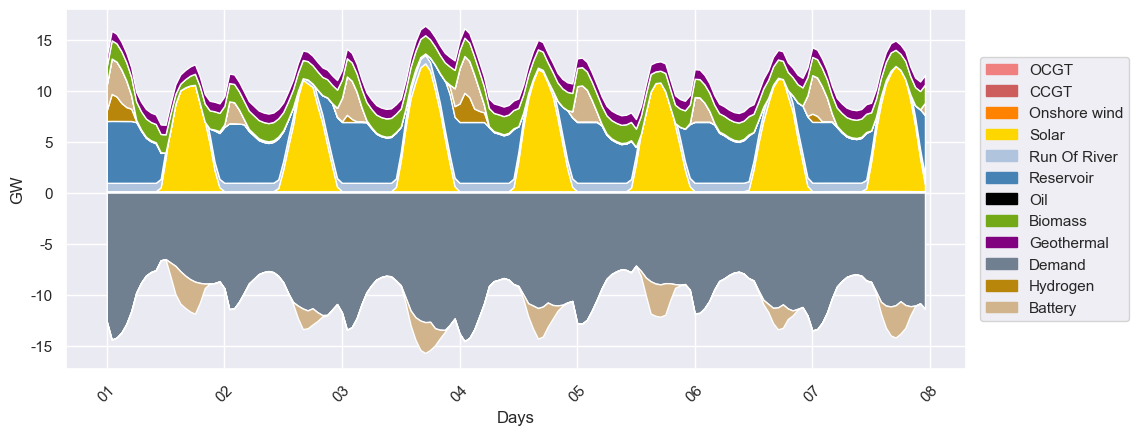

                   p_nom     p_nom_opt
carrier                               
CCGT        1.236000e+02  1.236000e+02
OCGT        0.000000e+00  0.000000e+00
biomass     9.900000e+01  1.793000e+03
geothermal  5.500000e+01  9.350000e+02
load        2.200000e+10  2.200000e+10
oil         0.000000e+00  0.000000e+00
onwind      4.500000e+01  4.728087e+01
ror         8.637700e+02  8.637700e+02
solar       1.004000e+02  1.790811e+04

hydro storage : p_nom: 6077.32  p_nom_opt: 6077.32


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16304\3842210715.py:148: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


In [92]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

#solved_network = os.getcwd() +  "/results/networks/results_updateRepository/elec_s_4_ec_lcopt_Co2L-4H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

#n = pypsa.Network(solved_network)
n = n_solve

first_date = "2013-01-01"
second_date = "2013-01-07"
OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]

demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1


size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
else:
    biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]
else:
    H2 = np.zeros(size)
    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    
if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)


# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 4))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])

i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 

i=0
nH2 = []
pH2=[]
for i in H2:
    if i < 0:
        nH2.append(i)
    else:
        nH2.append(0) 
for i in battery:
    if i > 0:
        pH2.append(i)
    else:
        pH2.append(0) 



OCGT_color='lightcoral'
CCGT_color='indianred'
Onwind_color='#ff8200'
Solar_color='gold'
ror_color='lightsteelblue'
reservoir_color='steelblue'
H2_color='darkgoldenrod'
battery_color='tan'
oil_color='black'
biomass_color='#73A917'
demand_color='slategrey'
geothermal_color = 'purple'

A = plt.stackplot(OCGT.index,OCGT,CCGT,Onwind,solar,ror,reservoir, H2, pbattery, oil, biomass, geothermal,
colors=[OCGT_color,CCGT_color,Onwind_color,Solar_color,ror_color,reservoir_color,H2_color,battery_color,oil_color,biomass_color,geothermal_color], zorder = 3)
plt.stackplot(OCGT.index,demand,nbattery, colors=[demand_color,battery_color], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Days')

OCGT_patch = mpatches.Patch(color=OCGT_color, label ='OCGT')
CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')
H2_patch = mpatches.Patch(color=H2_color, label ='Hydrogen')
battery_patch = mpatches.Patch(color=battery_color, label ='Battery')
oil_patch = mpatches.Patch(color=oil_color, label ='Oil')
biomass_patch = mpatches.Patch(color=biomass_color, label ='Biomass')
load_patch = mpatches.Patch(color=demand_color, label ='Demand')
geothermal_patch = mpatches.Patch(color=geothermal_color, label ='Geothermal')


handles=[OCGT_patch,CCGT_patch,wind_patch,solar_patch,ror_patch,reservoir_patch,oil_patch,biomass_patch,geothermal_patch,load_patch,H2_patch,battery_patch]

ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.19, 0.5))

image_format = 'eps' # e.g .png, .svg, etc.

#fig.savefig('energy_dispatch_run4.eps', format=image_format, dpi=1200)

plt.show()

gen_cap = n.generators.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))


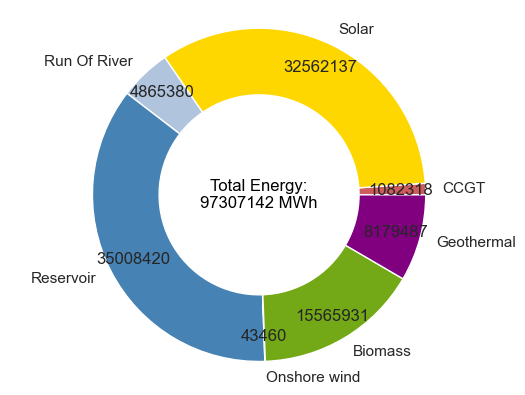

In [93]:

import matplotlib.pyplot as plt
first_date = "2013-01-01"
second_date = "2014-01-01"

time_aggregation = 1   #number hour hours considered by snapshot

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]*time_aggregation
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]*time_aggregation
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]*time_aggregation
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]*time_aggregation


size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]*time_aggregation
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]*time_aggregation
else:
    biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]*time_aggregation
else:
    CCGT = np.zeros(size)

if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]*time_aggregation
else:
    H2 = np.zeros(size)
    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]*time_aggregation
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)*time_aggregation
else:
    reservoir = np.zeros(size)

if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)


# Original data
labels = ['OCGT', 'CCGT', 'Solar', 'Run Of River', 'Reservoir', 'Onshore wind', 'Oil', 'Biomass', 'Geothermal']
sizes = [OCGT.sum(), CCGT.sum(), solar.sum(), ror.sum(), reservoir.sum(),Onwind.sum(), oil.sum(), biomass.sum(), geothermal.sum()]
colors = [OCGT_color, CCGT_color, Solar_color, ror_color, reservoir_color,Onwind_color, oil_color, biomass_color, geothermal_color]

# Filter data based on size > 0.5
filtered_labels = []
filtered_sizes = []
filtered_colors = []

for label, size, color in zip(labels, sizes, colors):
    if size > 10:
        filtered_labels.append(label)
        filtered_sizes.append(size)
        filtered_colors.append(color)

# Calculate the total sum of energy production
total_production = sum(filtered_sizes)

# Function to format the label text with actual values
def format_label(value):
    int_value = int(value)
    return str(int_value)

# Generate the pie chart
plt.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors, autopct=lambda x: str(int(round(x * total_production / 100))), pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total Energy:\n{int(total_production)} MWh', fontsize=12, color='black', ha='center', va='center')

#plt.savefig('energy_pie_run4.eps', format=image_format, dpi=1200)
plt.show()


<AxesSubplot:xlabel='snapshot'>

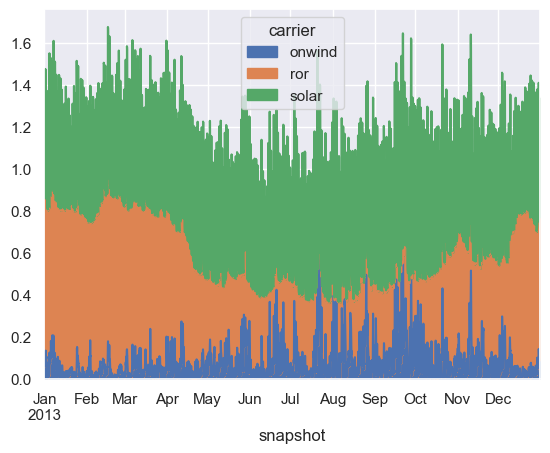

In [94]:
n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean().plot(kind = "area")

In [95]:
import xarray as xr

# Provide the file path
file_path = "C:/Users/Lenovo/Desktop/pypsa-earth/cutouts/southamerica-2013-era5.nc"

# Open the NetCDF file using xarray
ds = xr.open_dataset(file_path)

# Display the contents of the NetCDF file
ds

# Access the 'wnd100m' variable and convert it to a DataFrame
wnd100m_df = ds['wnd100m'].to_dataframe()

# Display the DataFrame
wnd100m_df

lon   lat   wnd100m
time                y     x                          
2013-01-01 00:00:00 -23.4 -70.2 -70.2 -23.4  2.673863
                          -69.9 -69.9 -23.4  2.915177
                          -69.6 -69.6 -23.4  3.518828
                          -69.3 -69.3 -23.4  4.107057
                          -69.0 -69.0 -23.4  4.250835
...                               ...   ...       ...
2013-12-31 23:00:00 -9.3  -58.2 -58.2  -9.3  2.138795
                          -57.9 -57.9  -9.3  1.863115
                          -57.6 -57.6  -9.3  1.602079
                          -57.3 -57.3  -9.3  1.531172
                          -57.0 -57.0  -9.3  1.628613

[18921600 rows x 3 columns]